# library import:

In [1]:
import nltk
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import urllib
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import urllib.request
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples,silhouette_score
from array import *
from nltk.probability import FreqDist
import squarify
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import pickle

# data import:
## Loading the CSV where all URLs are stored

In [2]:
pib_corpus = pd.read_csv('E:/NLP_PROJECT/PIB_DATA.csv',encoding='unicode_escape')
pib_corpus['Content'] = "Will be filled"
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,Will be filled
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,Will be filled


# reading content from URL:
## extraction of web content by bs4

In [3]:
for i in range(0,len(pib_corpus),1):
    webUrl  = urllib.request.urlopen(pib_corpus.iloc[i,3])
    data = webUrl.read()
    raw = BeautifulSoup(data,"html.parser").get_text()
    pib_corpus.loc[i,"Content"] = raw
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...


# removing \n, \r:

In [4]:
def remove_unnes(text):
    text_unnes = text.replace('\n', ' ')
    text_unnes = text_unnes.replace('\r', ' ')
    return text_unnes

pib_corpus['content_clean'] = pib_corpus['Content'].apply(lambda x: remove_unnes(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...


In [10]:
def findingurl(string):
    regex = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    url = re.findall(regex,string)
    return(url)

In [11]:
pib_corpus['content_url'] = pib_corpus['content_clean'].apply(lambda x: findingurl(x))

In [14]:
for i in range(0,len(pib_corpus),1):
    print(pib_corpus['content_url'][i])

[]
[]
[]
['https://www.mohfw.gov.in/', 'https://www.mohfw.gov.in/pdf/coronvavirushelplinenumber.pdf', 'https://www.mohfw.gov.in/', 'https://www.mohfw.gov.in/pdf/coronvavirushelplinenumber.pdf']
[]
[]
['https://igot.gov.in/igot/).', 'https://igot.gov.in/igot/).']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


# removing punctuation :

In [5]:
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

pib_corpus['content_clean'] = pib_corpus['content_clean'].apply(lambda x: remove_punct(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...


# content tokenization:

In [6]:
pib_corpus['content_tokenized'] = pib_corpus['content_clean'].apply(lambda x: nltk.word_tokenize(x.lower()))
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p..."


# removing stopwards:

In [7]:
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopwords]
    return text

pib_corpus['content_nostop'] = pib_corpus['content_tokenized'].apply(lambda x: remove_stopwords(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m..."


# lemmatization of content:

In [8]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

pib_corpus['content_lemmatized'] = pib_corpus['content_nostop'].apply(lambda x: lemmatizing(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


# content without number:

In [9]:
pib_corpus['w/o_num'] = "Will be filled"
wolist = []
for i in range(0,len(pib_corpus),1) :
    
    for j in range(0,len(pib_corpus['content_lemmatized'][i]),1) :
        text = pib_corpus['content_lemmatized'][i][j]
        run = re.sub('[0-9]+', '', text)
        wolist.append(run)
    
    pib_corpus.loc[i,"w/o_num"] = wolist
    wolist=[]
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, , crore, t..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


# removing some extra words:

In [10]:
extra_words = ["","\"","\'","ü","अन्न","अभियान","आत्मनिर्भर","कुष्ठावस्थाविकलांगभरणपोषणअनुदान",
               "भारत","वृद्धावस्थाकिसानपेंशनयोजना","–","–i","–rch","—","‘","’","“","”","•","₹"]
def remove_extra(some_text):
    text = [word for word in some_text if word not in extra_words]
    return text

pib_corpus['w/o_num'] = pib_corpus['w/o_num'].apply(lambda x: remove_extra(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, crore, tre..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


# removing stopwards:

In [11]:
pib_corpus['w/o_num'] = pib_corpus['w/o_num'].apply(lambda x: remove_stopwords(x))
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, crore, tre..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


# removing word with length < 3:

In [12]:
pib_corpus['w/o_num_updated'] = "Will be filled"
sh_list = []

for j in range(0,len(pib_corpus),1) :
    
    for i in range(0,len(pib_corpus['w/o_num'][j])) :
        
        if len(pib_corpus['w/o_num'][j][i]) > 2:
            
            main = pib_corpus['w/o_num'][j][i]
            sh_list.append(main)
    
    pib_corpus.loc[j,"w/o_num_updated"] = sh_list
    sh_list=[]

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num,w/o_num_updated
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, crore, tre...","[ministry, health, family, welfare, crore, tre..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


# blank analyzer initialization for vectorization:

In [13]:
def clean_text(text):
    return text

# seed setting:

In [14]:
random.seed(10)

# process 1 :
## by taking w/o_num_updated (which consists of all words without number and lengths are also greater than 2) column

## TF-DIF vectorization:

In [15]:
tfidf_vect_wo_number = TfidfVectorizer(analyzer=clean_text)
X_tfidf_wo_number = tfidf_vect_wo_number.fit_transform(pib_corpus['w/o_num_updated'])
print(X_tfidf_wo_number.shape)
X_tfidf_df_wo_number = pd.DataFrame(X_tfidf_wo_number.toarray())
X_tfidf_df_wo_number.columns = tfidf_vect_wo_number.get_feature_names()
print(X_tfidf_df_wo_number.head(2))

(56, 3462)
   aadhaar  aadhaarpan  aatma  aatmanirbhar    aayog  abhiyaan  abhiyan  \
0      0.0         0.0    0.0           0.0  0.03515       0.0      0.0   
1      0.0         0.0    0.0           0.0  0.00000       0.0      0.0   

   abhwcs  abiding      able  ...  yet  yogi    yojana  yojanabr  yojna  yoy  \
0     0.0      0.0  0.027599  ...  0.0   0.0  0.066248       0.0    0.0  0.0   
1     0.0      0.0  0.000000  ...  0.0   0.0  0.000000       0.0    0.0  0.0   

   zhu  zhusaid  zone  zoonotic  
0  0.0      0.0   0.0       0.0  
1  0.0      0.0   0.0       0.0  

[2 rows x 3462 columns]


## kmeans for this process:
### using elbow method

C:\Users\Arijit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


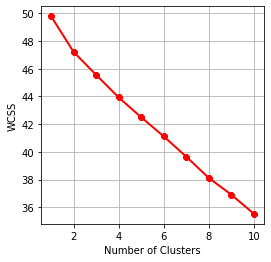

In [16]:
wcss_1=[]
for k in range(1,11):
    kmeans_1=KMeans(n_clusters=k, init="k-means++")
    kmeans_1.fit(X_tfidf_df_wo_number)
    wcss_1.append(kmeans_1.inertia_)
plt.figure(figsize=(4,4))
plt.grid()
plt.plot(range(1, 11), wcss_1, linewidth=2, color="red", marker="8")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [17]:
print(KneeLocator(range(1, 11), wcss_1, curve="convex", direction="decreasing").elbow)

None


C:\Users\Arijit\anaconda3\lib\site-packages\kneed\knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


## kmeans for this process:
### using silhouette score method

In [18]:
si_avg_1=[]
for k in range(2,11):
    kmeans_2=KMeans(n_clusters=k, init="k-means++")
    kmeans_2.fit(X_tfidf_df_wo_number)
    cluster_labels_1 = kmeans_2.fit_predict(X_tfidf_df_wo_number)
    silhouette_avg_1 = silhouette_score(X_tfidf_df_wo_number, cluster_labels_1)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg_1)
    si_avg_1.append(silhouette_avg_1)

For n_clusters = 2 The average silhouette_score is : 0.030324602099338255
For n_clusters = 3 The average silhouette_score is : 0.026467636916915442
For n_clusters = 4 The average silhouette_score is : 0.030489444928916882
For n_clusters = 5 The average silhouette_score is : 0.03662209576208257
For n_clusters = 6 The average silhouette_score is : 0.040999095420956685
For n_clusters = 7 The average silhouette_score is : 0.03464452353706673
For n_clusters = 8 The average silhouette_score is : 0.043731028524790334
For n_clusters = 9 The average silhouette_score is : 0.045753363001990656
For n_clusters = 10 The average silhouette_score is : 0.05275596522424188


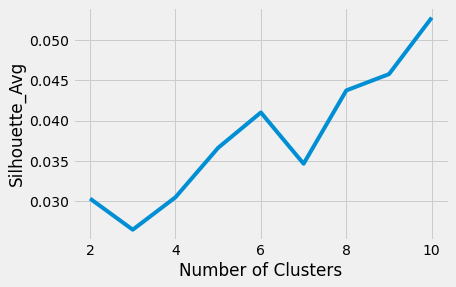

In [19]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), si_avg_1)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette_Avg")
plt.show()

## using PCA:

In [20]:
si_avg_pca=[]
si_avg_pca_list=[]
for i in range(2,21,1) :
    x_standard = StandardScaler().fit_transform(X_tfidf_df_wo_number)
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(x_standard)
    principalDf = pd.DataFrame(data = principalComponents)
    
    for k in range(2,11):
        kmeans_pca=KMeans(n_clusters=k, init="k-means++")
        kmeans_pca.fit(principalDf)
        cluster_labels_pca = kmeans_pca.fit_predict(principalDf)
        silhouette_avg_pca = silhouette_score(principalDf, cluster_labels_pca)
        print("For n_clusters =", k,"and PCA:",i, "The average silhouette_score is :", silhouette_avg_pca)
        si_avg_pca.append(silhouette_avg_pca)
    
    si_avg_pca_list.append(si_avg_pca)
    si_avg_pca=[]

For n_clusters = 2 and PCA: 2 The average silhouette_score is : 0.930017231614988
For n_clusters = 3 and PCA: 2 The average silhouette_score is : 0.8937938530752326
For n_clusters = 4 and PCA: 2 The average silhouette_score is : 0.8029043318994893
For n_clusters = 5 and PCA: 2 The average silhouette_score is : 0.6008767553468474
For n_clusters = 6 and PCA: 2 The average silhouette_score is : 0.41562552384812684
For n_clusters = 7 and PCA: 2 The average silhouette_score is : 0.3761382990322237
For n_clusters = 8 and PCA: 2 The average silhouette_score is : 0.38487530506068784
For n_clusters = 9 and PCA: 2 The average silhouette_score is : 0.3919940824004688
For n_clusters = 10 and PCA: 2 The average silhouette_score is : 0.3866211172192292
For n_clusters = 2 and PCA: 3 The average silhouette_score is : 0.9057669395440875
For n_clusters = 3 and PCA: 3 The average silhouette_score is : 0.8666551702845473
For n_clusters = 4 and PCA: 3 The average silhouette_score is : 0.8561012173351311
Fo

For n_clusters = 2 and PCA: 13 The average silhouette_score is : 0.748549377351824
For n_clusters = 3 and PCA: 13 The average silhouette_score is : 0.6240485035644378
For n_clusters = 4 and PCA: 13 The average silhouette_score is : 0.589798653435378
For n_clusters = 5 and PCA: 13 The average silhouette_score is : 0.5991531300222707
For n_clusters = 6 and PCA: 13 The average silhouette_score is : 0.601723981639681
For n_clusters = 7 and PCA: 13 The average silhouette_score is : 0.6074420809250197
For n_clusters = 8 and PCA: 13 The average silhouette_score is : 0.6133038297749813
For n_clusters = 9 and PCA: 13 The average silhouette_score is : 0.6157802115483191
For n_clusters = 10 and PCA: 13 The average silhouette_score is : 0.6197676459509192
For n_clusters = 2 and PCA: 14 The average silhouette_score is : 0.7310739930559897
For n_clusters = 3 and PCA: 14 The average silhouette_score is : 0.5961045886636985
For n_clusters = 4 and PCA: 14 The average silhouette_score is : 0.58424527931

In [21]:
pca1_row_name=[]
for i in range(2,21,1):
    txt = "pca "+ str(i)
    pca1_row_name.append(txt)
pca1_col_name=[]
for i in range(2,11,1):
    txt = "n_cluster "+ str(i)
    pca1_col_name.append(txt)

In [22]:
pca_table_1 = pd.DataFrame(si_avg_pca_list,columns = pca1_col_name,index=pca1_row_name)
pca_table_1

,n_cluster 2,n_cluster 3,n_cluster 4,n_cluster 5,n_cluster 6,n_cluster 7,n_cluster 8,n_cluster 9,n_cluster 10
pca 2,0.930017,0.893794,0.802904,0.600877,0.415626,0.376138,0.384875,0.391994,0.386621
pca 3,0.905767,0.866655,0.856101,0.744916,0.749689,0.654102,0.334254,0.345085,0.334294
pca 4,0.874692,0.815377,0.809984,0.759760,0.618653,0.656801,0.649997,0.645485,0.414700
pca 5,0.857928,0.788882,0.787681,0.739161,0.751303,0.705098,0.671307,0.609547,0.610153
pca 6,0.839369,0.759470,0.758026,0.742644,0.741909,0.731349,0.689982,0.344495,0.387368
pca 7,0.830938,0.749358,0.748238,0.744382,0.749063,0.745026,0.748813,0.616506,0.621165
pca 8,0.818494,0.730663,0.728975,0.723895,0.727208,0.736264,0.741867,0.742858,0.612389
pca 9,0.804507,0.708767,0.705966,0.699058,0.702722,0.710311,0.718236,0.723287,0.729926
pca 10,0.789293,0.687114,0.681773,0.667643,0.677552,0.683329,0.691908,0.695973,0.701223
pca 11,0.774672,0.663916,0.657069,0.645478,0.648879,0.655076,0.662746,0.667166,0.671377


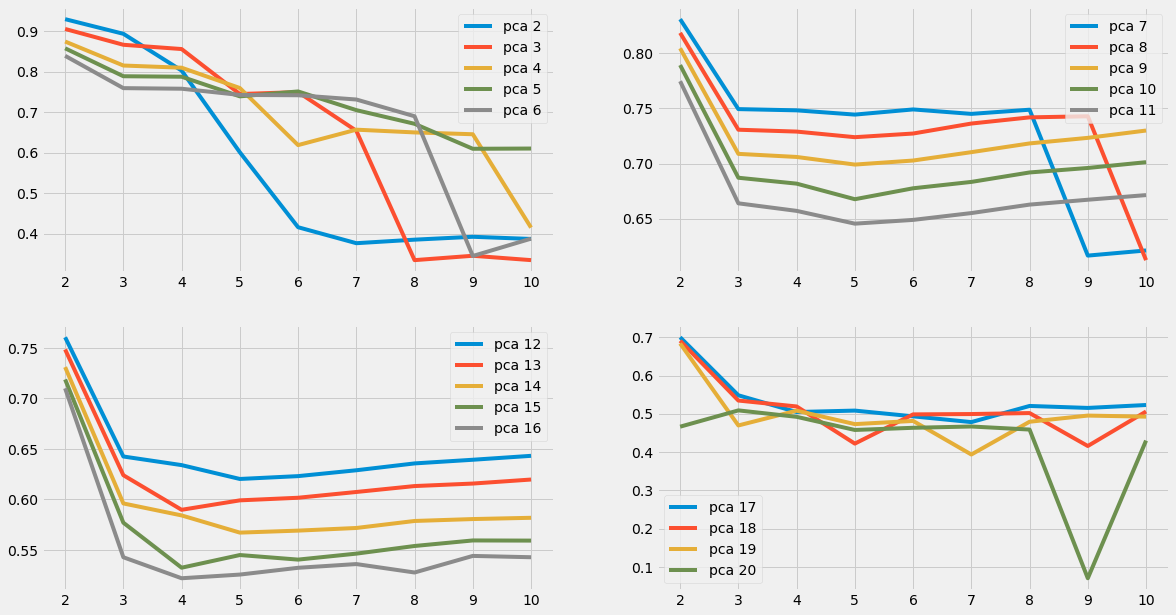

In [23]:
figure, axis = plt.subplots(2,2,figsize=(18,10))

for i in range(0,5,1):
    axis[0,0].plot(range(2, 11), pca_table_1.iloc[i])
axis[0,0].legend(pca1_row_name[0:5])

for i in range(5,10,1):
    axis[0,1].plot(range(2, 11), pca_table_1.iloc[i])
axis[0,1].legend(pca1_row_name[5:10])

for i in range(10,15,1):
    axis[1,0].plot(range(2, 11), pca_table_1.iloc[i])
axis[1,0].legend(pca1_row_name[10:15])

for i in range(15,19,1):
    axis[1,1].plot(range(2, 11), pca_table_1.iloc[i])
axis[1,1].legend(pca1_row_name[15:19])

plt.show()

# process 2 :
## by taking most frequent 35 words

## most_common column creation:

In [24]:
pib_corpus['most_common'] = "Will be filled"
com_list=[]
for i in range(0,len(pib_corpus),1) :
    
    for j in range(0,35,1) :
        fdist = FreqDist(pib_corpus['w/o_num_updated'][i])
        a = [fdist.most_common(35)]
        arun = a[0][j][0]
        com_list.append(arun)
    
    pib_corpus.loc[i,"most_common"] = com_list
    com_list=[]
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num,w/o_num_updated,most_common
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, crore, tre...","[ministry, health, family, welfare, crore, tre...","[health, crore, treatment, ayushman, bharat, h..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[health, insurance, covid, ministry, pradhan, ..."


## TF-DIF vectorization:

In [25]:
tfidf_vect_common = TfidfVectorizer(analyzer=clean_text)
X_tfidf_common = tfidf_vect_common.fit_transform(pib_corpus['most_common'])
print(X_tfidf_common.shape)
X_tfidf_df_common = pd.DataFrame(X_tfidf_common.toarray())
X_tfidf_df_common.columns = tfidf_vect_common.get_feature_names()
print(X_tfidf_df_common.head(2))

(56, 759)
   aatma  aatmanirbhar  abhiyaan   abpmjay  accelerating   account  achieve  \
0    0.0           0.0       0.0  0.195071           0.0  0.000000      0.0   
1    0.0           0.0       0.0  0.000000           0.0  0.152243      0.0   

   achieved  across  act  ...  wise  within  woman    worker  working  world  \
0       0.0     0.0  0.0  ...   0.0     0.0    0.0  0.000000      0.0    0.0   
1       0.0     0.0  0.0  ...   0.0     0.0    0.0  0.146948      0.0    0.0   

   worth  would  year    yojana  
0    0.0    0.0   0.0  0.160791  
1    0.0    0.0   0.0  0.000000  

[2 rows x 759 columns]


## kmeans for this process:
### using elbow method

C:\Users\Arijit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


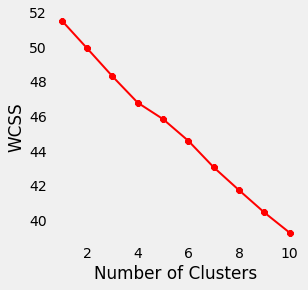

In [26]:
wcss_3=[]
for k in range(1,11):
    kmeans_3=KMeans(n_clusters=k, init="k-means++")
    kmeans_3.fit(X_tfidf_df_common)
    wcss_3.append(kmeans_3.inertia_)
plt.figure(figsize=(4,4))
plt.grid()
plt.plot(range(1, 11), wcss_3, linewidth=2, color="red", marker="8")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [27]:
print(KneeLocator(range(1, 11), wcss_3, curve="convex", direction="decreasing").elbow)

None


C:\Users\Arijit\anaconda3\lib\site-packages\kneed\knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


## kmeans for this process:
### using silhouette score method

In [28]:
si_avg_2=[]
for k in range(2,11):
    kmeans_4=KMeans(n_clusters=k, init="k-means++")
    kmeans_4.fit(X_tfidf_df_common)
    cluster_labels_2 = kmeans_4.fit_predict(X_tfidf_df_common)
    silhouette_avg_2 = silhouette_score(X_tfidf_df_common, cluster_labels_2)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg_2)
    si_avg_2.append(silhouette_avg_2)

For n_clusters = 2 The average silhouette_score is : 0.014426288056507681
For n_clusters = 3 The average silhouette_score is : 0.01413257323569027
For n_clusters = 4 The average silhouette_score is : 0.017785700911007063
For n_clusters = 5 The average silhouette_score is : 0.01836162172256011
For n_clusters = 6 The average silhouette_score is : 0.020170385124884362
For n_clusters = 7 The average silhouette_score is : 0.021598488121759102
For n_clusters = 8 The average silhouette_score is : 0.02262814825465018
For n_clusters = 9 The average silhouette_score is : 0.021897703873875234
For n_clusters = 10 The average silhouette_score is : 0.029334368503517838


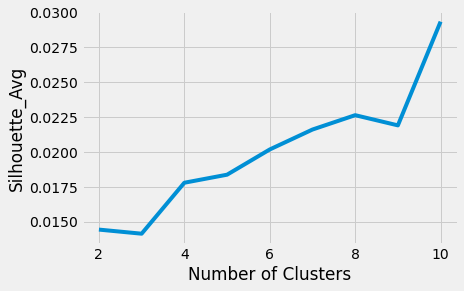

In [29]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), si_avg_2)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette_Avg")
plt.show()

## using PCA:

In [30]:
si_avg_pca=[]
si_avg_pca_list=[]
for i in range(2,21,1) :
    x_standard = StandardScaler().fit_transform(X_tfidf_df_common)
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(x_standard)
    principalDf = pd.DataFrame(data = principalComponents)
    
    for k in range(2,11):
        kmeans_pca=KMeans(n_clusters=k, init="k-means++")
        kmeans_pca.fit(principalDf)
        cluster_labels_pca = kmeans_pca.fit_predict(principalDf)
        silhouette_avg_pca = silhouette_score(principalDf, cluster_labels_pca)
        print("For n_clusters =", k,"and PCA:",i, "The average silhouette_score is :", silhouette_avg_pca)
        si_avg_pca.append(silhouette_avg_pca)
    
    si_avg_pca_list.append(si_avg_pca)
    si_avg_pca=[]

For n_clusters = 2 and PCA: 2 The average silhouette_score is : 0.6073081515620823
For n_clusters = 3 and PCA: 2 The average silhouette_score is : 0.5386858917810599
For n_clusters = 4 and PCA: 2 The average silhouette_score is : 0.4884221721907923
For n_clusters = 5 and PCA: 2 The average silhouette_score is : 0.47180422375517767
For n_clusters = 6 and PCA: 2 The average silhouette_score is : 0.4683795490577526
For n_clusters = 7 and PCA: 2 The average silhouette_score is : 0.44770135040997355
For n_clusters = 8 and PCA: 2 The average silhouette_score is : 0.43462239458760227
For n_clusters = 9 and PCA: 2 The average silhouette_score is : 0.44517399690038867
For n_clusters = 10 and PCA: 2 The average silhouette_score is : 0.41287728301783816
For n_clusters = 2 and PCA: 3 The average silhouette_score is : 0.4469996028263627
For n_clusters = 3 and PCA: 3 The average silhouette_score is : 0.3674401326148095
For n_clusters = 4 and PCA: 3 The average silhouette_score is : 0.409837880679304

For n_clusters = 10 and PCA: 12 The average silhouette_score is : 0.176735884418847
For n_clusters = 2 and PCA: 13 The average silhouette_score is : 0.10180296520361938
For n_clusters = 3 and PCA: 13 The average silhouette_score is : 0.2232063029502386
For n_clusters = 4 and PCA: 13 The average silhouette_score is : 0.1245004246646541
For n_clusters = 5 and PCA: 13 The average silhouette_score is : 0.11601813474225889
For n_clusters = 6 and PCA: 13 The average silhouette_score is : 0.11675060753702725
For n_clusters = 7 and PCA: 13 The average silhouette_score is : 0.23843561266218188
For n_clusters = 8 and PCA: 13 The average silhouette_score is : 0.08233185227655383
For n_clusters = 9 and PCA: 13 The average silhouette_score is : 0.09956069223704407
For n_clusters = 10 and PCA: 13 The average silhouette_score is : 0.15301640580881756
For n_clusters = 2 and PCA: 14 The average silhouette_score is : 0.2314760240341671
For n_clusters = 3 and PCA: 14 The average silhouette_score is : 0.2

In [31]:
pca_table_2 = pd.DataFrame(si_avg_pca_list,columns = pca1_col_name,index=pca1_row_name)
pca_table_2

,n_cluster 2,n_cluster 3,n_cluster 4,n_cluster 5,n_cluster 6,n_cluster 7,n_cluster 8,n_cluster 9,n_cluster 10
pca 2,0.607308,0.538686,0.488422,0.471804,0.468380,0.447701,0.434622,0.445174,0.412877
pca 3,0.447000,0.367440,0.409838,0.409929,0.384523,0.352888,0.384874,0.357613,0.358864
pca 4,0.416480,0.288176,0.286484,0.315231,0.334962,0.309774,0.310000,0.311931,0.324099
pca 5,0.340419,0.360916,0.236234,0.264071,0.261922,0.289267,0.283175,0.300736,0.292295
pca 6,0.360997,0.282233,0.249184,0.254738,0.282130,0.302749,0.285977,0.252894,0.288751
pca 7,0.335524,0.177023,0.210768,0.213230,0.285049,0.209212,0.186923,0.215001,0.207178
pca 8,0.241364,0.286980,0.165557,0.337452,0.162468,0.190929,0.202730,0.222883,0.222973
pca 9,0.208947,0.167688,0.250017,0.175913,0.270040,0.193733,0.204320,0.181649,0.196604
pca 10,0.268504,0.113164,0.081875,0.109743,0.151808,0.148649,0.167693,0.132228,0.154345
pca 11,0.162141,0.095627,0.247214,0.123216,0.130181,0.153879,0.139412,0.134613,0.159909


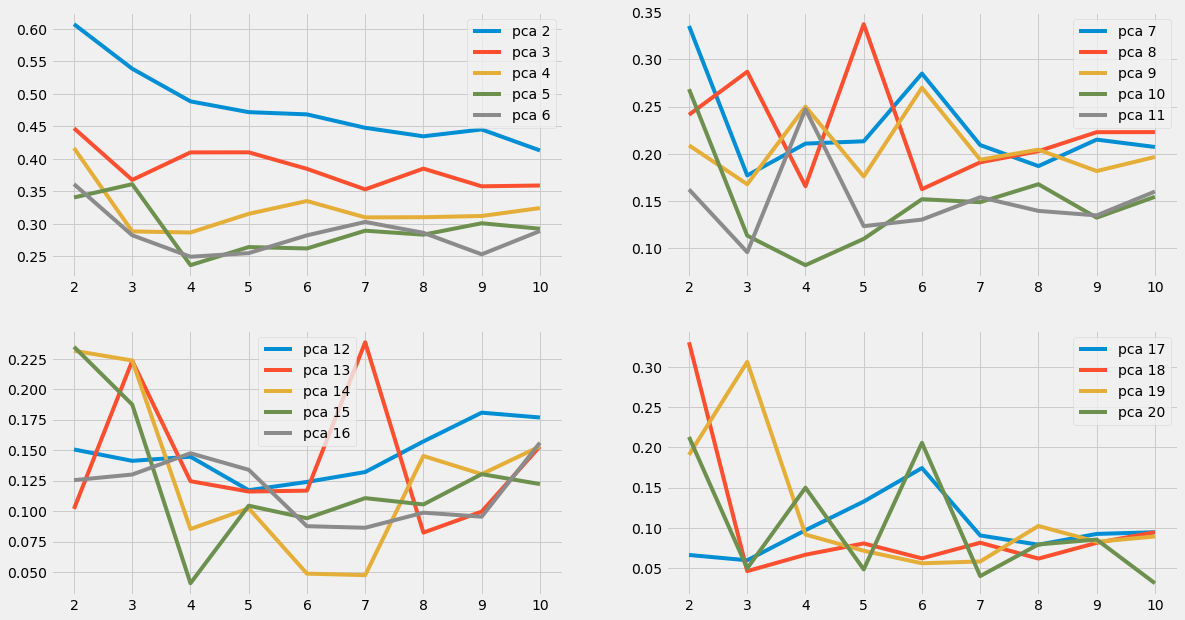

In [32]:
figure, axis = plt.subplots(2,2,figsize=(18,10))

for i in range(0,5,1):
    axis[0,0].plot(range(2, 11), pca_table_2.iloc[i])
axis[0,0].legend(pca1_row_name[0:5])

for i in range(5,10,1):
    axis[0,1].plot(range(2, 11), pca_table_2.iloc[i])
axis[0,1].legend(pca1_row_name[5:10])

for i in range(10,15,1):
    axis[1,0].plot(range(2, 11), pca_table_2.iloc[i])
axis[1,0].legend(pca1_row_name[10:15])

for i in range(15,19,1):
    axis[1,1].plot(range(2, 11), pca_table_2.iloc[i])
axis[1,1].legend(pca1_row_name[15:19])

plt.show()

# tree plot:

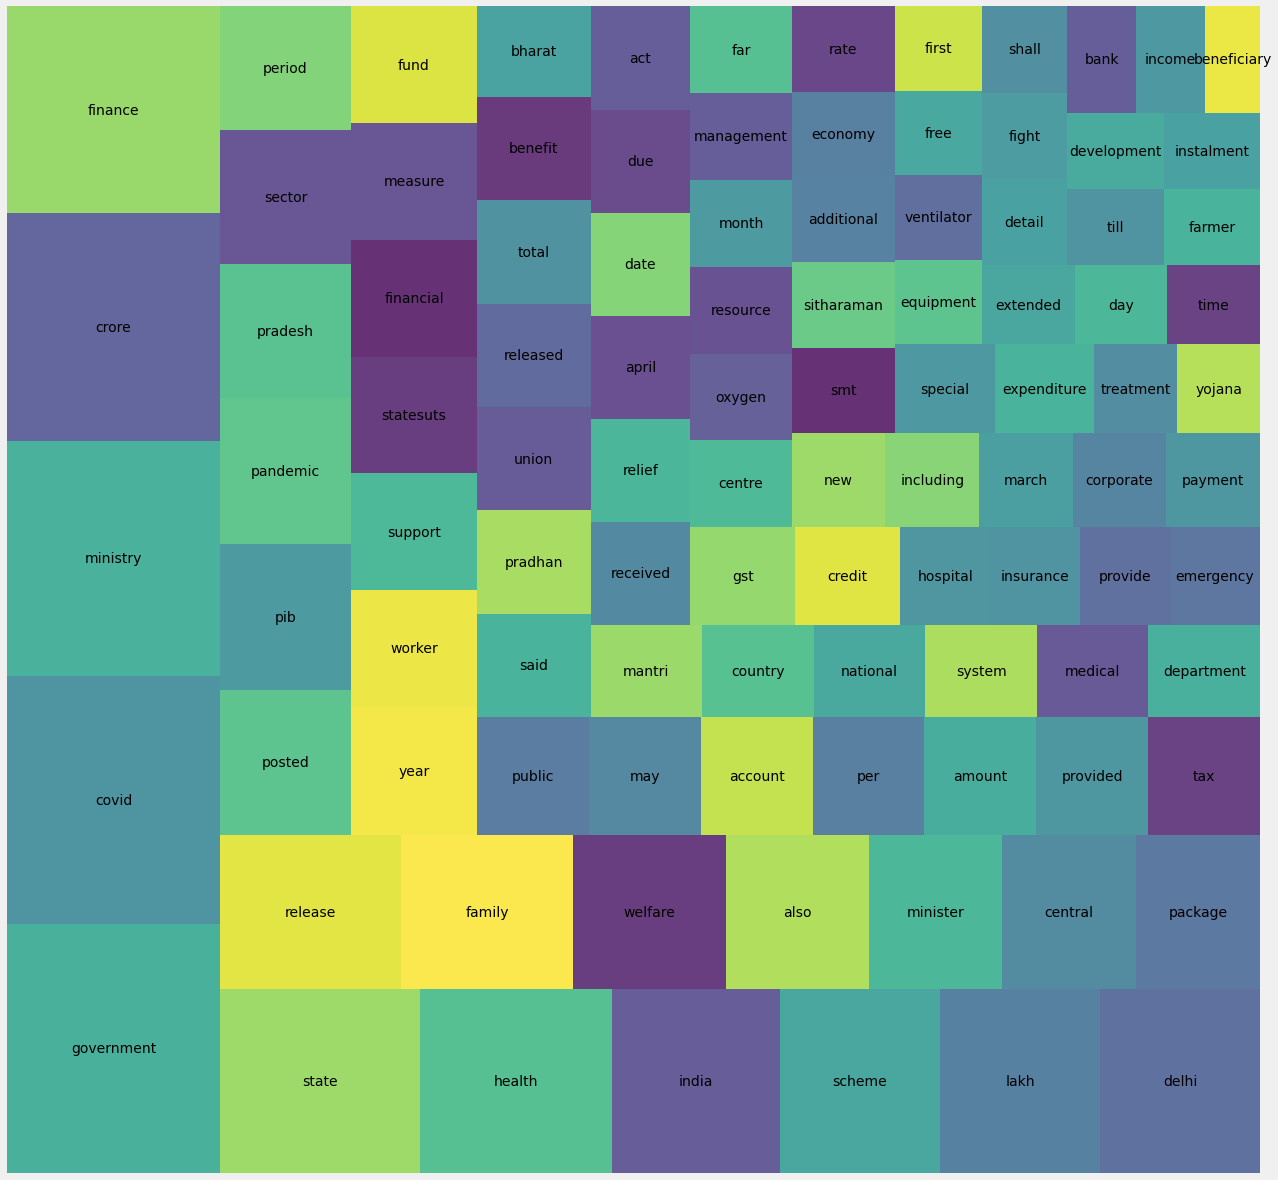

In [33]:
tree =[]

for i in range(0,len(pib_corpus),1) :
    
    for j in range(0,35,1) :
        fdist = FreqDist(pib_corpus['w/o_num_updated'][i])
        a = [fdist.most_common(35)]
        arun = a[0][j][0]
        com_list.append(arun)
    
    tree.append(com_list)
    com_list=[]
    
tree_flat = [item for sublist in tree for item in sublist]
freq_mc=FreqDist(tree_flat).most_common(100)
tree_table = pd.DataFrame(freq_mc, columns = ['Word', 'Count'])

fig, ax = plt.subplots(1, figsize = (20,20))
squarify.plot(sizes=tree_table['Count'], 
              label=tree_table['Word'], 
              alpha=.8 )
plt.axis('off')
plt.show()